In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

# Pandas
<!-- requirement: images/Data_Frame_Data_Series.png -->
<!-- requirement: small_data/fha_by_tract.csv -->
<!-- requirement: small_data/2013_Gaz_tracts_national.tsv -->


Pandas is Python's answer to R.  It's a good tool for small(ish) data analysis -- i.e. when everything fits into memory.

The basic new "noun" in pandas is the **data frame**.

## Nouns (objects) in Pandas


### Data Frames


Like a table, with rows and columns (e.g. as in SQL).  Except:
  - The rows can be indexed by something interesting (there is special support for labels like categorical and timeseries data).  This is especially useful when you have timeseries data with potentially missing data points.
  - Cells can store Python objects. Like in SQL, columns are type homogeneous.
  - Instead of "NULL", the name for a non-existent value is "NA".  Unlike R, Python's data frames only support NAs in columns of some data types (basically: floating point numbers and 'objects') -- but this is mostly a non-issue (because it will "up-cast" integers to float64, etc.)
  

### Data Series:

These are named columns of a DataFrame (more correctly, a dataframe is a dictionary of Series).  The entries of the series have homogenous type.

![Data Frame Data Series](images/Data_Frame_Data_Series.png)
[comment]: https://docs.google.com/drawings/d/1eQOWaG37cH6Uo13zfRVPWsA77F0U4WVG2y06Z3NOtAU/edit

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# a data frame
df1 = pd.DataFrame({
    'number': [1, 2, 3],
    'animal': ['cat', 'dog', 'mouse']
})

df1

,animal,number
0,cat,1
1,dog,2
2,mouse,3


In [3]:
df1['animal']  # a series

0      cat
1      dog
2    mouse
Name: animal, dtype: object

In [4]:
df1.animal    # not always possible. solutions?

0      cat
1      dog
2    mouse
Name: animal, dtype: object

In [5]:
# data type
# "object" ~= "string"
# http://stackoverflow.com/q/21018654/3217870
df1.dtypes

animal    object
number     int64
dtype: object

In [6]:
# the same data frame
df2 = pd.DataFrame([
    ('cat', 1),
    ('dog', 2),
    ('mouse', 3),
], columns=['animal', 'number'])

np.all(df1 == df2)

True

## Verbs (operations) in Pandas

  
Pandas provides a "batteries-included" basic data analysis:
  - **Loading data:** `read_csv`, `read_table`, `read_sql`, and `read_html`
  - **Selection, filtering, and aggregation** (i.e. SQL-type operations): There's a special syntax for `SELECT`ing.  There's the `merge` method for `JOIN`ing.  There's also an easy syntax for what in SQL is a mouthful: Creating a new column whose value is computed from another column -- with the bonus that now the computations can use the full power of Python (though it might be faster if it didn't).
  - **"Pivot table" style aggregation:** If you're an Excel cognoscenti, you may appreciate this.
  - **NA handling:** Like R's data frames, there is good support for transforming NA values with default values / averaging tricks / etc.
  - **Basic statistics:** e.g. `mean`, `median`, `max`, `min`, and the convenient `describe`.
  - **Plugging into more advanced analytics:** Okay, this isn't batteries included.  But still, it plays reasonably with `sklearn`.
  - **Visualization:** For instance `plot` and `hist`.
  
We'll go through a little on all of these in the context of an example.

We're going to explore a dataset of mortgage insurance issued by the Federal Housing Authority (FHA).  The data is broken down by census tract and tells us how big of a player the FHA is in each tract (how many homes etc.).

## Loading data (and basic statistics / visualization)

In [7]:
names =["State_Code", "County_Code", "Census_Tract_Number", "NUM_ALL", "NUM_FHA", "PCT_NUM_FHA", "AMT_ALL", "AMT_FHA", "PCT_AMT_FHA"]
df = pd.read_csv('small_data/fha_by_tract.csv', names=names)  # Loading a CSV file, without a header (so we have to provide field names)
df.head()

,State_Code,County_Code,Census_Tract_Number,NUM_ALL,NUM_FHA,PCT_NUM_FHA,AMT_ALL,AMT_FHA,PCT_AMT_FHA
0,8.0,75.0,NaN,1,1,100.0,258,258,100.0
1,28.0,49.0,103.01,1,1,100.0,71,71,100.0
2,40.0,3.0,NaN,1,1,100.0,215,215,100.0
3,39.0,113.0,603.00,3,3,100.0,206,206,100.0
4,12.0,105.0,124.04,2,2,100.0,303,303,100.0


In [8]:
df['GEOID'] = df['Census_Tract_Number']*100 + 10**6 * df['County_Code'] \
    + 10**9 * df['State_Code']   # A computed field!
df.head()

,State_Code,County_Code,Census_Tract_Number,NUM_ALL,NUM_FHA,PCT_NUM_FHA,AMT_ALL,AMT_FHA,PCT_AMT_FHA,GEOID
0,8.0,75.0,NaN,1,1,100.0,258,258,100.0,NaN
1,28.0,49.0,103.01,1,1,100.0,71,71,100.0,2.804901e+10
2,40.0,3.0,NaN,1,1,100.0,215,215,100.0,NaN
3,39.0,113.0,603.00,3,3,100.0,206,206,100.0,3.911306e+10
4,12.0,105.0,124.04,2,2,100.0,303,303,100.0,1.210501e+10


To drop a column:

In [9]:
df.drop('GEOID', axis=1).head()

,State_Code,County_Code,Census_Tract_Number,NUM_ALL,NUM_FHA,PCT_NUM_FHA,AMT_ALL,AMT_FHA,PCT_AMT_FHA
0,8.0,75.0,NaN,1,1,100.0,258,258,100.0
1,28.0,49.0,103.01,1,1,100.0,71,71,100.0
2,40.0,3.0,NaN,1,1,100.0,215,215,100.0
3,39.0,113.0,603.00,3,3,100.0,206,206,100.0
4,12.0,105.0,124.04,2,2,100.0,303,303,100.0


In [20]:
print(type(df.iloc[0].GEOID))
print type(np.nan)

<type 'numpy.float64'>
<type 'float'>


Most operations produce copies (unless `inplace=True` is specified).  The `df` object still has the GEOID column.

In [21]:
'GEOID' in df.columns

True

Rows can also be dropped.  Note that the indices do not reset.  The index is associated with the row, not with the order.

In [22]:
df.drop(0, axis=0).head()

,State_Code,County_Code,Census_Tract_Number,NUM_ALL,NUM_FHA,PCT_NUM_FHA,AMT_ALL,AMT_FHA,PCT_AMT_FHA,GEOID
1,28.0,49.0,103.01,1,1,100.0,71,71,100.0,2.804901e+10
2,40.0,3.0,NaN,1,1,100.0,215,215,100.0,NaN
3,39.0,113.0,603.00,3,3,100.0,206,206,100.0,3.911306e+10
4,12.0,105.0,124.04,2,2,100.0,303,303,100.0,1.210501e+10
5,12.0,86.0,9808.00,1,1,100.0,188,188,100.0,1.208698e+10


By default, rows are indexed by their position.  However, any column can be made into an index:

In [23]:
df.set_index('State_Code').head(6)

,County_Code,Census_Tract_Number,NUM_ALL,NUM_FHA,PCT_NUM_FHA,AMT_ALL,AMT_FHA,PCT_AMT_FHA,GEOID
State_Code,,,,,,,,,
8.0,75.0,NaN,1,1,100.0,258,258,100.0,NaN
28.0,49.0,103.01,1,1,100.0,71,71,100.0,2.804901e+10
40.0,3.0,NaN,1,1,100.0,215,215,100.0,NaN
39.0,113.0,603.00,3,3,100.0,206,206,100.0,3.911306e+10
12.0,105.0,124.04,2,2,100.0,303,303,100.0,1.210501e+10
12.0,86.0,9808.00,1,1,100.0,188,188,100.0,1.208698e+10


Multiple levels of indexing is possible:

In [24]:
df.set_index(['State_Code', 'County_Code']).head(6)

Census_Tract_Number  NUM_ALL  NUM_FHA  PCT_NUM_FHA  \
State_Code County_Code                                                       
8.0        75.0                         NaN        1        1        100.0   
28.0       49.0                      103.01        1        1        100.0   
40.0       3.0                          NaN        1        1        100.0   
39.0       113.0                     603.00        3        3        100.0   
12.0       105.0                     124.04        2        2        100.0   
           86.0                     9808.00        1        1        100.0   

                        AMT_ALL  AMT_FHA  PCT_AMT_FHA         GEOID  
State_Code County_Code                                               
8.0        75.0             258      258        100.0           NaN  
28.0       49.0              71       71        100.0  2.804901e+10  
40.0       3.0              215      215        100.0           NaN  
39.0       113.0            206      206        100.0  3.911306e+10  
12.0       105.0            303      303        100.0  1.210501e+10  
           86.0             188      188        100.0  1.208698e+10

An index can be turned back into a column:

In [25]:
df.set_index('State_Code').reset_index().head()

,State_Code,County_Code,Census_Tract_Number,NUM_ALL,NUM_FHA,PCT_NUM_FHA,AMT_ALL,AMT_FHA,PCT_AMT_FHA,GEOID
0,8.0,75.0,NaN,1,1,100.0,258,258,100.0,NaN
1,28.0,49.0,103.01,1,1,100.0,71,71,100.0,2.804901e+10
2,40.0,3.0,NaN,1,1,100.0,215,215,100.0,NaN
3,39.0,113.0,603.00,3,3,100.0,206,206,100.0,3.911306e+10
4,12.0,105.0,124.04,2,2,100.0,303,303,100.0,1.210501e+10


In [26]:
print "Percentage of mortages in each census tract insured by FHA"
df['PCT_AMT_FHA'].describe()

Percentage of mortages in each census tract insured by FHA


count    72035.000000
mean        29.703179
std         24.037779
min          0.000000
25%         10.780800
50%         24.753900
75%         44.207550
max        100.000000
Name: PCT_AMT_FHA, dtype: float64

In [27]:
# on entire dataframe
df.describe()

,State_Code,County_Code,Census_Tract_Number,NUM_ALL,NUM_FHA,PCT_NUM_FHA,AMT_ALL,AMT_FHA,PCT_AMT_FHA,GEOID
count,72034.000000,71984.000000,71040.000000,72035.000000,72035.000000,72035.000000,7.203500e+04,72035.000000,72035.000000,7.104000e+04
mean,28.322528,85.612636,2534.598023,36.970389,9.741667,28.566878,7.886092e+03,1689.278851,29.703179,2.837319e+10
std,16.459507,98.672445,3451.173223,53.975403,15.187832,22.404545,1.302542e+04,2800.346300,24.037779,1.648784e+10
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000e+00,0.000000,0.000000,1.001020e+09
25%,13.000000,29.000000,103.020000,13.000000,2.000000,11.111100,1.551000e+03,281.000000,10.780800,1.301596e+10
50%,28.000000,63.000000,442.010000,27.000000,6.000000,25.000000,4.168000e+03,932.000000,24.753900,2.804900e+10
75%,42.000000,109.000000,4503.012500,48.000000,13.000000,41.935500,9.668000e+03,2197.000000,44.207550,4.200348e+10
max,72.000000,840.000000,9922.010000,9477.000000,1932.000000,100.000000,1.575871e+06,331515.000000,100.000000,7.215375e+10


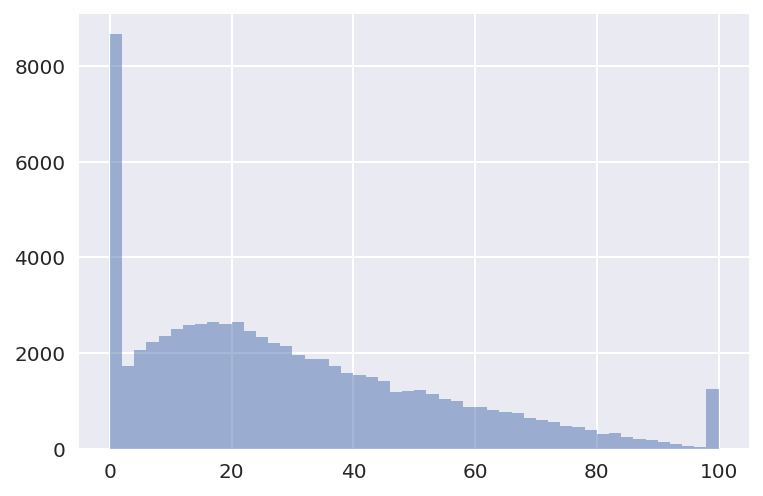

In [28]:
#this is genius.
df['PCT_AMT_FHA'].hist(bins=50, alpha=0.5)

The above distribution looks skewed, so let's look at its logarithm.

count    72035.000000
mean         8.170124
std          1.429644
min          1.098612
25%          7.347300
50%          8.335431
75%          9.176680
max         14.270319
Name: LOG_AMT_ALL, dtype: float64


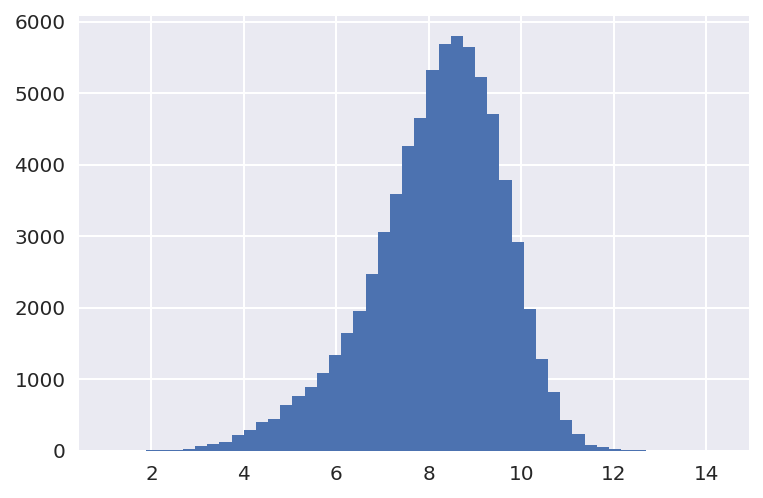

In [29]:
df['LOG_AMT_ALL'] = np.log1p(df['AMT_ALL'])  # Create a new column to examine
print df['LOG_AMT_ALL'].describe()

df['AMT_ALL'].apply(np.log1p).hist(bins=50)  # Or apply a function to each element

## Indexing data frames


Indexing by a column name yields a data series.

In [30]:
#I always screw this up.
df['State_Code'].head()

0     8.0
1    28.0
2    40.0
3    39.0
4    12.0
Name: State_Code, dtype: float64

Indexing by a list of column names gives another data frame.

In [31]:
df[['State_Code', 'County_Code']].head()

,State_Code,County_Code
0,8.0,75.0
1,28.0,49.0
2,40.0,3.0
3,39.0,113.0
4,12.0,105.0


**Question:** What will this return?

In [32]:
type(df[['State_Code']])

pandas.core.frame.DataFrame

A data frame is an iterator that yields the column names:

In [34]:
[col for col in df]

['State_Code',
 'County_Code',
 'Census_Tract_Number',
 'NUM_ALL',
 'NUM_FHA',
 'PCT_NUM_FHA',
 'AMT_ALL',
 'AMT_FHA',
 'PCT_AMT_FHA',
 'GEOID',
 'LOG_AMT_ALL']

To select specific rows, you can try:

In [35]:
df[:3]

,State_Code,County_Code,Census_Tract_Number,NUM_ALL,NUM_FHA,PCT_NUM_FHA,AMT_ALL,AMT_FHA,PCT_AMT_FHA,GEOID,LOG_AMT_ALL
0,8.0,75.0,NaN,1,1,100.0,258,258,100.0,NaN,5.556828
1,28.0,49.0,103.01,1,1,100.0,71,71,100.0,2.804901e+10,4.276666
2,40.0,3.0,NaN,1,1,100.0,215,215,100.0,NaN,5.375278


To index a particular element of the frame, use the `.loc` attribute.  It takes index and column names.

In [36]:
df.loc[3, 'State_Code']

39.0

Both can be sliced.  Unusually for Python, both endpoints are included in the slice.

In [37]:
df.loc[0:3, 'State_Code':'Census_Tract_Number']

,State_Code,County_Code,Census_Tract_Number
0,8.0,75.0,NaN
1,28.0,49.0,103.01
2,40.0,3.0,NaN
3,39.0,113.0,603.00


Position-based indexing is available in the `.iloc` attribute.

In [38]:
df.iloc[3, 0]

39.0

The usual slicing convention is used for `.iloc`.

In [39]:
# damn
df.iloc[0:3, 0:3]

,State_Code,County_Code,Census_Tract_Number
0,8.0,75.0,NaN
1,28.0,49.0,103.01
2,40.0,3.0,NaN


## Filtering data


Now the `df[...]` notation is very flexible:
  - It accepts column names (strings and lists of strings);
  - It accepts column numbers (so long as there is no ambiguity with column names);
  - It accepts _binary data series!_
  
This means that you can write

        df[ df['column_name2']==MD & ( df['column_name1']==5 | df['column_name1']==6 ) ]
   
for what you would write in SQL as

>         SELECT * FROM df WHERE
            column_name2='MD" AND (column_name1=5 OR column_name1=6)
            
Boolean operators on a data frame return a data series of bools.

In [44]:
(df['State_Code'] == 1).head()
df[df['State_Code'] == 1 & (df['Census_Tract_Number'] == 9613)]

,State_Code,County_Code,Census_Tract_Number,NUM_ALL,NUM_FHA,PCT_NUM_FHA,AMT_ALL,AMT_FHA,PCT_AMT_FHA,GEOID,LOG_AMT_ALL
23999,1.0,49.0,9613.0,16,4,25.0,2184,799,36.5842,1.049961e+09,7.689371


These can be combined with the (bitwise) boolean operators.  Note that, due to operator precedence, you want to wrap the individual comparisons in parentheses.

In [41]:
((df['State_Code'] == 1) & (df['Census_Tract_Number'] == 9613)).head()

0    False
1    False
2    False
3    False
4    False
dtype: bool

Data frames accept indexing by boolean series.

In [42]:
df[df['State_Code'] == 5].head()

,State_Code,County_Code,Census_Tract_Number,NUM_ALL,NUM_FHA,PCT_NUM_FHA,AMT_ALL,AMT_FHA,PCT_AMT_FHA,GEOID,LOG_AMT_ALL
77,5.0,119.0,32.05,1,1,100.0,113,113,100.0000,5.119003e+09,4.736198
186,5.0,69.0,19.01,2,2,100.0,224,224,100.0000,5.069002e+09,5.416100
904,5.0,119.0,12.00,2,2,100.0,154,154,100.0000,5.119001e+09,5.043425
986,5.0,119.0,40.01,4,4,100.0,445,445,100.0000,5.119004e+09,6.100319
1252,5.0,119.0,5.00,5,4,80.0,307,301,98.0456,5.119000e+09,5.730100


**Note:** select rows by binary data series only if they share the same data index!

**Exercise:**
1. Plot the histogram of percentages for different states in the same graph to compare them.
2. Notice that there is a spike at 100%.  This means that the FHA has insured 100% of the houses in that census tract.  See what happens to the histogram when we restrict it to the case where the total number of loans is non-negligible.

## Joining data


The analogue of a

>             
    SELECT * 
        FROM df1
        INNER JOIN df2 
        ON df1.field_name=df2.field_name;

is

    df_joined = df1.merge(df2, on='field_name')

You can also do left / right / outer joins, mix-and-match column names, etc.  For that consult the Pandas documentation. (The example below will do a left join.)

Of course, just looking at the distribution of insurance by census tract isn't interesting unless we know more about the census tract.

In [45]:
# The first row is the column names, so we don't have to specify those
df_geo = pd.read_csv('small_data/2013_Gaz_tracts_national.tsv', sep='\t')
df_geo.head()

,USPS,GEOID,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,AL,1001020100,9809939,36312,3.788,0.014,32.481794,-86.490249
1,AL,1001020200,3340498,5846,1.290,0.002,32.475758,-86.472468
2,AL,1001020300,5349274,9054,2.065,0.003,32.474024,-86.459703
3,AL,1001020400,6382705,16244,2.464,0.006,32.471030,-86.444835
4,AL,1001020500,11397734,48412,4.401,0.019,32.458916,-86.421817


In [46]:
df_joined = df.merge(df_geo, on='GEOID', how='left')
df_joined.head()

,State_Code,County_Code,Census_Tract_Number,NUM_ALL,NUM_FHA,PCT_NUM_FHA,AMT_ALL,AMT_FHA,PCT_AMT_FHA,GEOID,LOG_AMT_ALL,USPS,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,8.0,75.0,NaN,1,1,100.0,258,258,100.0,NaN,5.556828,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28.0,49.0,103.01,1,1,100.0,71,71,100.0,2.8049e+10,4.276666,MS,8162270.0,22648.0,3.151,0.009,32.365904,-90.262379
2,40.0,3.0,NaN,1,1,100.0,215,215,100.0,NaN,5.375278,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,39.0,113.0,603.00,3,3,100.0,206,206,100.0,3.91131e+10,5.332719,OH,5382347.0,0.0,2.078,0.000,39.729932,-84.268323
4,12.0,105.0,124.04,2,2,100.0,303,303,100.0,1.2105e+10,5.717028,FL,105120002.0,1800522.0,40.587,0.695,28.224489,-81.739745


## Aggregating data


The analog of SQL's `GROUP BY` is

    grouped = df.groupby(['field_name1', ...])...

The above is analogous to
>             
    SELECT mean(df.value1), std(df.value2) 
        FROM df
        GROUP BY df.field_name1, ...

Pandas is somewhat more flexible in how you can use grouping, not requiring you to specify an aggregation function up front.  The `.groupby()` method that can later be aggregated.

In [47]:
usps_groups = df_joined.groupby('USPS')
usps_groups

The reason Pandas doesn't require you to specify an aggregation function up front is because the groupby method by itself does little work. It returns a `DataFrameGroupBy` datatype that contains a dictionary of group keys to lists of row numbers.

In [ ]:
print type(usps_groups.groups)
usps_groups.groups['AK'][:5]

I can retrieve the group of data associated with one key:

In [ ]:
usps_groups.get_group('AK')[:5]

Observe that this is the same as:

In [ ]:
df_joined.iloc[usps_groups.groups['AK'][:5]]

In [ ]:
usps_groups.mean().head()  # Takes the mean of the rows in each group

In [ ]:
# This is the analog of
# SELECT USPS, SUM(AMT_FHA), SUM(AMT_ALL), ... FROM df GROUP BY USPS;
df_by_state = usps_groups['AMT_FHA', 'AMT_ALL', 'NUM_FHA', 'NUM_ALL'].sum()
df_by_state.head()

In [ ]:
df_by_state['PCT_AMT_FHA'] = 100.0 * df_by_state['AMT_FHA']  / df_by_state['AMT_ALL']

# This sure looks different than the census-tract level histogram!
df_by_state['PCT_AMT_FHA'].hist(bins=20)

You can also specify a specific aggregation function per column:

In [ ]:
usps_groups['NUM_FHA', 'NUM_ALL'].agg({'NUM_FHA': np.sum, 'NUM_ALL': np.mean}).head()

The groupby function is especially useful when you define your own aggregation functions. Here, we define a function that returns the row for the census track located farthest to the north. The apply function attempts to 'combine results together in an intelligent way.' The list of Series objects from each call to `farthest_north` for each USPS code is collapsed into a single DataFrame table.

In [ ]:
def farthest_north(state_df):
    # descending sort, then select row 0
    # the datatype will be a pandas Series
    return state_df.sort_values('INTPTLAT', ascending=False).iloc[0]

df_joined.groupby('USPS').apply(farthest_north)[:10]

## Sorting by indices and columns


We can sort by the row (or column) index.

In [ ]:
df_by_state.sort_index(ascending=False).head()

We can also sort by the value in a column

In [ ]:
df_by_state.sort_values('AMT_FHA').head()

## Cuts and qcuts


Pandas has built in histogram-like and quantile behavior through `cut` and `qcut`, respectively.  A call to it on a single dataframe column (a Series) returns the binning and which bin each row goes in.  `cut` returns a uniform binning between the maximum and minimum values, while `qcut` returns bins with an equal number of elements, i.e. quantiles.

The command returns a list of each element and which bin it was placed in, followed by a list of all bins.

In [ ]:
#The sample command takes a random subsample, here just for display purposes
sampled_df = df.sample(frac=0.1)

In [ ]:
pd.cut(sampled_df['LOG_AMT_ALL'],10)

In [ ]:
#You can see the bins are fairly unequal
pd.qcut(sampled_df['LOG_AMT_ALL'],10)

The `labels=False` command in cut or qcut gives just the bin number instead of the bin label

In [ ]:
pd.qcut(sampled_df['LOG_AMT_ALL'],10,labels=False)

## Unique values


As in SQL, pandas can compute unique values, value counts, and test for membership

In [ ]:
df['State_Code'].unique()[:10]

In [ ]:
df['State_Code'].value_counts().head()

In [ ]:
df['State_Code'].isin(df['State_Code'].head(3)).head()

## Handling missing and NA data



When you read in a CSV file / SQL database there are often "NA" (or "null", "None", etc.) values.  The CSV reader has a special field for specifying how this is denoted, and SQL has the built-in notion of NULL.  Pandas provides some tools for working with these -- they are generally similar to (and a little bit worse than) `R`.

Note that these methods are by default not in place -- that is, they create a new series and do not change the original one.

For more details: http://pandas.pydata.org/pandas-docs/stable/missing_data.html

In [ ]:
df['GEOID'][:10]

`.isnull()` and `.notnull()` test for null-ness and return a Boolean series.

In [ ]:
df['GEOID'].isnull()[:10]

`.dropna()` removes the rows with null data

In [ ]:
df['GEOID'].size, df['GEOID'].dropna().size

`.fillna()` replaces N/A values with another value.  `.interpolate()` replaces null values by (linear, or quadratic, or...) interpolation.  There is support for indexing by times (not necessarily equally spaced), etc. in the documentation.

In [ ]:
df['fill_0'] = df['GEOID'].fillna(0)                          # Fills constant value, here 0
df['fill_forward'] = df['GEOID'].fillna(method='ffill')       # Fill forwards
df['fill_back'] = df['GEOID'].fillna(method='bfill', limit=5) # Fill backwards, at most 5
df['fill_mean'] = df['GEOID'].fillna(df['GEOID'].mean())      # Fills constant value, here the mean (imputation)
df['fill_interp'] = df['GEOID'].interpolate()                 # Fills interpolated value
df[['GEOID', 'fill_0', 'fill_forward', 'fill_back', 'fill_mean', 'fill_interp']][:10]

### Note

N/A values are (usually) smartly ignored when performing other calculations on dataframes. For example, when using string methods on series:

In [ ]:
text_series = df['GEOID'].replace(0, np.nan).apply(str)
print text_series[:10]

In [ ]:
text_series[:10].str.split('.')

Applying mean on numeric data ignores NA's by default (check docs):

In [ ]:
df['GEOID'].mean()

## Manipulating strings


Element-wise string operations are available through the `.str` attribute.

In [ ]:
states = df_joined['USPS'].dropna()
states[states.str.contains('A')].head()

## Indices in Pandas


Pandas indices allow us to handle data naturally.  **Elements are associated based on their index, not their order.**

In [ ]:
s1 = pd.Series([1,2,3], index=['a', 'b', 'c'])
s2 = pd.Series([3,2,1], index=['c', 'b', 'a'])
s1 + s2

In [ ]:
s3 = pd.Series([3,2,1], index=['c', 'd', 'e'])
s1 + s3

Missing values get a NaN, but this can be replaced by a fill value of your choice.

In [ ]:
s1.add(s3, fill_value=0)

## Function application and mapping


For element-wise function application, the most straightforward thing to do is to apply numpy functions to these objects:

In [ ]:
df1 = pd.DataFrame(np.arange(24).reshape(4,6))

np.sin(df1)

This relies on numpy functions automatically broadcasting themselves to work element-wise.  To apply a pure-python function to each element, use the `.applymap()` method.

In [ ]:
df1.applymap(lambda x: "%.2f" % x)

However, sometimes you want to compute things column-wise or row-wise.  In this case, you will need to use the `apply` method. 

For example, the following takes the range of each column.

In [ ]:
df1.apply(lambda x: x.max() - x.min())

And this takes the range of reach row.

In [ ]:
df1.apply(lambda x: x.max() - x.min(), axis=1)

### Pandas HTML data import example


Pandas takes a "batteries included" approach and throws in a whole lot of convenience functions.  For instance it has import functions for a variety of formats.  One of the pleasant surprises is a command `read_html` that's meant to automate the process of extracting tabular data from HTML.  In particular, it works pretty well with tables on Wikipedia.  

Let's do an example: We'll try to extract the list of the world's tallest structures from
http://en.wikipedia.org/wiki/List_of_tallest_buildings_and_structures_in_the_world.

In [ ]:
# Fix version ID so that results are stable
url = "https://en.wikipedia.org/w/index.php?title=List_of_tallest_buildings_and_structures&oldid=783685865"

dfs = pd.read_html(url, header=0, parse_dates=False)

# There are several tables on the page.  By inspection we can figure out which one we want
tallest = dfs[3]

# The coordinates column needs to be fixed up.  This is a bit of string parsing:
def clean_lat_long(s):
    try:
        parts = s.split("/")
    except AttributeError:
        return (None, None)
    if len(parts) < 3:
        return (None, None)
    m = re.search(r"(\d+[.]\d+);[^\d]*(\d+[.]\d+)[^\d]", parts[2])
    if not m:
        return (None, None)
    return (m.group(1), m.group(2))

tallest['Clean_Coordinates'] = tallest['Coordinates'].apply(clean_lat_long)
tallest['Latitude'] = tallest['Clean_Coordinates'].apply(lambda x:x[0])
tallest['Longitude'] = tallest['Clean_Coordinates'].apply(lambda x:x[1])

# Et voila
tallest.head()

**Exercise**

1. Parse the table rankings of [UK universities available on Wikipedia](https://en.wikipedia.org/wiki/Rankings_of_universities_in_the_United_Kingdom):

## Pandas Timestamps


Pandas comes with excellent tools for managing temporal data. Central to this is the Timestamp class, which can infer timestamps from many sensible inputs:

In [ ]:
print pd.Timestamp('July 4, 2016')
print pd.Timestamp('Monday, July 4, 2016')
print pd.Timestamp('Tuesday, July 4th, 2016')  # notice it ignored 'Tuesday'
print pd.Timestamp('Monday, July 4th, 2016 05:00 PM')
print pd.Timestamp('04/07/2016T17:20:13.123456')
print pd.Timestamp(1467651600000000000)  # number of ns since the epoch, 1/1/1970

It can manage timestamps with timezones:

In [ ]:
july4 = pd.Timestamp('Monday, July 4th, 2016 05:00 PM').tz_localize('US/Eastern')
labor_day = pd.Timestamp('9/5/2016 12:00', tz='US/Eastern')
thanksgiving = pd.Timestamp('11/24/2016 16:00')  # no timezone

Pandas can do calculations on Timestamps if they are both localized to the same timezone or neither has a timezone.

In [ ]:
print labor_day - july4
# print thanksgiving - july4  # generates an error

The time series offsets are useful for calculating dates relative to another date. Observe it skips over weekend days but is oblivious to holidays. Pandas does support [Custom Calendars](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#holidays-holiday-calendars) if you need them.

In [ ]:
from pandas.tseries.offsets import BDay, Day, BMonthEnd

print july4 + Day(5)  # 5 calendar days later, a Saturday.
print july4 + BDay(5)  # 5 business days later, or the following Monday.
print july4 - BDay(1)  # 1 business day earlier, or the previous Friday.
print july4 + BMonthEnd(1)  # last business day of the month.

Pandas can generate a range of dates. Here, we generate a list of business days in January of 2016:

In [ ]:
business_days = pd.date_range('1/1/2016', '1/31/2016', freq='B')
business_days

This can in turn be used in as a DataFrame index:

In [ ]:
time_df = pd.DataFrame(np.random.rand(len(business_days)),
                    index=business_days,
                   columns=['random'])
time_df.head()

The same timezone functions are still available.

In [ ]:
time_df.tz_localize('UTC').tz_convert('US/Pacific').head()

## Multi-indices, stacking, and pivot tables


Data frames can contain multiple indices for rows or columns.  For example, grouping by two columns will produce a two-level row index.

In [ ]:
grouped = df.groupby(['State_Code', 'County_Code'])[['NUM_ALL', 'NUM_FHA']].sum()
grouped.head()

A row index can be converted into a column index with the `.unstack()` method:

In [ ]:
grouped.unstack().head()

And the `.stack()` method does the opposite:

In [ ]:
np.all(grouped.unstack().stack() == grouped)

This can be done with one step with the `pivot_table()` function.

In [ ]:
pd.pivot_table(df, index='State_Code', columns='County_Code',
               values=['NUM_ALL', 'NUM_FHA'], aggfunc=np.sum).head()

You may already by familiar with pivot tables in Excel.  These work similarly, and area  good tool for changing the dependent and independent variables for aggregations of data. See http://pandas.pydata.org/pandas-docs/stable/reshaping.html for more information.

## Plugging into more advanced analytics


Almost any "advanced analytics" tool in the Python ecosystem is going to take as input `np.array` type arrays.  You can access the underlying array of a data frame column as

        df['column'].values
        
Many of them take `nd.array` whose underlying data can be accessed by 

        df.values
        
directly.  *Most* of the time, they will take `df['column']` and `df` without needing to look at values.

This is particularly important if you want to use Pandas with the sklearn library. See this [blog post](http://www.markhneedham.com/blog/2013/11/09/python-making-scikit-learn-and-pandas-play-nice/) for an example.

### Exit Tickets

1. Describe several situations where you would prefer to use Pandas, and several where you'd prefer SQL.
1. Write the syntax for slicing the rows of a dataframe according to a filtering criterion.
1. Write the syntax for selecting, adding, or removing columns of a dataframe.

*Copyright &copy; 2015 The Data Incubator.  All rights reserved.*